# Build Historical Data

My data strategy is to get as much as I can from the torrent below, and add as much as I can with PRAW. I can only get 1000 submissions so Ill sort by new and by top. This is tricky since Ill probably have some dates missing, but its the best I can think of. 

Pushshift is dead, and thats the only other major solution I know of. 

In [1]:
import json
from pathlib import Path
from typing import List, Dict

from datasets import Dataset
import pandas as pd
from tqdm.autonotebook import tqdm

proj_dir_path = Path().cwd().parent
proj_dir = str(proj_dir_path)

## Get Torrent Data

Download the subreddit data and put it in [data/torrent](data/torrent) as described here: https://www.reddit.com/r/pushshift/comments/11ef9if/separate_dump_files_for_the_top_20k_subreddits/

Install zstd, or decompress in the best way you can find. Its a little tricky. Here, Im putting the `ndsjon` in [data/processed](data/processed).

In [2]:
!zstd -f -d "$proj_dir"/data/torrents/BestofRedditorUpdates_submissions.zst -o "$proj_dir"/data/torrents/BestofRedditorUpdates_submissions.ndjson > /dev/null 2>&1

Use `ls` to make sure it worked.

In [3]:
%ls -alF  "$proj_dir"/data/torrents/BestofRedditorUpdates_submissions.ndjson

-rw-r--r--@ 1 derekthomas  staff  76007896 Oct 20 10:48 /Users/derekthomas/projects/spaces/dataset-creator-reddit/data/torrents/BestofRedditorUpdates_submissions.ndjson


## Read from torrent file

Read in our ndjson line by line.

In [4]:
data = []
with open(proj_dir + '/data/torrents/BestofRedditorUpdates_submissions.ndjson', 'r') as file:
    for line in file:
        item = json.loads(line)
        data.append(item)

We need to choose which keys to keep.

In [5]:
data[0]

{'all_awardings': [],
 'allow_live_comments': False,
 'archived': False,
 'author': '[deleted]',
 'author_flair_background_color': '',
 'author_flair_css_class': None,
 'author_flair_template_id': None,
 'author_flair_text': None,
 'author_flair_text_color': 'dark',
 'awarders': [],
 'can_gild': False,
 'can_mod_post': False,
 'category': None,
 'content_categories': None,
 'contest_mode': False,
 'created_utc': 1580499608,
 'crosspost_parent': 't3_etguwh',
 'crosspost_parent_list': [{'all_awardings': [{'award_sub_type': 'GLOBAL',
     'award_type': 'global',
     'coin_price': 1800,
     'coin_reward': 0,
     'count': 4,
     'days_of_drip_extension': 31,
     'days_of_premium': 31,
     'description': 'Gives the author a month of Reddit Premium, which includes %{coin_symbol}700 Coins for that month, and shows a Platinum Award.',
     'end_date': None,
     'giver_coin_reward': None,
     'icon_format': None,
     'icon_height': 512,
     'icon_url': 'https://www.redditstatic.com/gol

In [6]:
keys_to_keep = ['created_utc', 'title', 'score', 'flair', 'link_flair_text', 'selftext', 'author', 'permalink', 'selftext']
filtered_data = [{k: d[k] for k in keys_to_keep if k in d} for d in data]

Verify our filtered_data looks correct.

In [7]:
filtered_data[0]

{'created_utc': 1580499608,
 'title': 'UPDATE: AITA for letting my brother call me "dad" and refusing to tell him the ugly truth?',
 'score': 1,
 'link_flair_text': None,
 'selftext': '[deleted]',
 'author': '[deleted]',
 'permalink': '/r/BestofRedditorUpdates/comments/ewtopo/update_aita_for_letting_my_brother_call_me_dad/'}

Put it in a dataframe

In [8]:
key_conversion = {
    'submission_content': 'content',
    'selftext': 'content',
    'author': 'poster',
    'date': 'date_utc',
    'created_utc': 'date_utc',
    'link_flair_text': 'flair',
    'upvotes': 'score',
    'link': 'permalink'
    # 'poster_link':  (No direct match)
}

In [9]:
torrent_df = pd.DataFrame(filtered_data)
torrent_df['created_utc'] = pd.to_datetime(torrent_df['created_utc'], unit='s')
torrent_df = torrent_df.rename(columns=key_conversion)
torrent_df['id'] = torrent_df.permalink.str.split('/').str[4]

torrent_df

date_utc                                              title  \
0    2020-01-31 19:40:08  UPDATE: AITA for letting my brother call me "d...   
1    2020-01-31 19:46:30  Younger brother thinks older brother is his da...   
2    2020-01-31 19:53:11  Stressed Father who wanted to cancel Christmas...   
3    2020-01-31 20:37:14  Man refuses to take girlfriend out to dinner b...   
4    2020-01-31 20:41:16         He pesters neighbor to cook for him for $5   
...                  ...                                                ...   
8388 2022-12-31 15:56:56  AITA for making my daughter share her presents...   
8389 2022-12-31 18:16:22             To All BORU contributors, Thank you :)   
8390 2022-12-31 19:52:50  Car was mistakenly towed from my own parking s...   
8391 2022-12-31 21:47:44  My (29F) husband (30M) has been going out with...   
8392 2022-12-31 23:04:03  AITA for reporting my best friend to the HR be...   

      score         flair                                            content  \
0         1          None                                          [deleted]   
1         7          AITA  Original post: https://www.reddit.com/r/AmIthe...   
2         9          AITA  [Original: AITA if I "cancel" Christmas becaus...   
3        23          AITA  **Original Post:** https://www.reddit.com/r/Am...   
4        15          AITA  [Original] (https://www.reddit.com/r/AmItheAss...   
...     ...           ...                                                ...   
8388      1     CONCLUDED                                          [removed]   
8389      1     CONCLUDED                                          [removed]   
8390   5743  INCONCLUSIVE  **I am not the original poster. Originally pos...   
8391      1     CONCLUDED                                          [removed]   
8392      1     CONCLUDED                                          [removed]   

                poster                                          permalink  \
0            [deleted]  /r/BestofRedditorUpdates/comments/ewtopo/updat...   
1         register2014  /r/BestofRedditorUpdates/comments/ewts8z/young...   
2         register2014  /r/BestofRedditorUpdates/comments/ewtvnr/stres...   
3         register2014  /r/BestofRedditorUpdates/comments/ewuj3d/man_r...   
4         register2014  /r/BestofRedditorUpdates/comments/ewulam/he_pe...   
...                ...                                                ...   
8388          anonziee  /r/BestofRedditorUpdates/comments/zzx36a/aita_...   
8389  IsItAcOnSeQuEnCe  /r/BestofRedditorUpdates/comments/10004zw/to_a...   
8390            Celany  /r/BestofRedditorUpdates/comments/10025jy/car_...   
8391         [deleted]  /r/BestofRedditorUpdates/comments/1004j93/my_2...   
8392         [deleted]  /r/BestofRedditorUpdates/comments/10061th/aita...   

           id  
0      ewtopo  
1      ewts8z  
2      ewtvnr  
3      ewuj3d  
4      ewulam  
...       ...  
8388   zzx36a  
8389  10004zw  
8390  10025jy  
8391  1004j93  
8392  10061th  

[8393 rows x 8 columns]

## Read PRAW Downloads

Basically I downloaded 1000 posts from praw in 2 ways, the 1000 most recent from `new` and the 1000 `top` posts. I needlessly saved it to file, but here is me adding that to the data I already have.

In [10]:
submissions = []
for submission_path in tqdm((proj_dir_path/'data'/'BestofRedditorUpdates').glob('*/*.json')):
    date, post_id = submission_path.stem.split('_')
    with open(submission_path) as file:
        submission = json.load(file)
        submissions.append(submission)

0it [00:00, ?it/s]

In [11]:
submission

{'submission_content': '**I am NOT the Original Poster. That is** u/throwaway970012390. He posted in r/AmItheAsshole, r/Advice, r/TrueOffMyChest and his own profile.\n\nThis is a **long, dark post.** Please read the trigger warnings and mood spoiler.\n\n**Trigger Warning:** >!drug use; suicide attempt; addiction; misandry; infidelity!<\n\n**Mood Spoiler:** >!depressing and frustrating!<\n\n**Original** [Post](https://www.reddit.com/r/AmItheAsshole/comments/12towpj/aita_38m_for_cutting_back_on_work_to_prove_a/)**: April 20, 2023**\n\nMy wife is usually an angel of a woman, but has recently gotten into a friendship with a woman whom I personally believe is a bad influence on her, not in a patronizing way, more of a "lay down with dogs, get up with fleas" type of situation.\n\nI never said anything about her childishness or her very radical misandry, because frankly it doesn\'t effect me.\n\nUntil it did. A few months ago my wife began pressuring me to do more around the house. Before I g

In [12]:
submission.keys()

dict_keys(['submission_content', 'poster', 'date', 'flair', 'title', 'upvotes', 'link', 'poster_link'])

In [13]:
def preprocess_praw_data(submissions: List[Dict], key_conversion: Dict[str, str]) -> pd.DataFrame:
    """
    Preprocesses praw data into a DataFrame.
    
    Parameters:
    - submissions: List of submission dictionaries.
    - key_conversion: Mapping of original to new column names.
    
    Returns:
    - pd.DataFrame: Preprocessed DataFrame.
    """
    
    # Convert the submissions list to a DataFrame
    praw_df = pd.DataFrame(submissions)
    
    # Convert 'date' column to datetime format
    praw_df.date = pd.to_datetime(praw_df.date)
    
    # Rename columns based on the provided mapping
    praw_df = praw_df.rename(columns=key_conversion)
    
    # Remove 'poster_link' column if it exists
    if 'poster_link' in praw_df.columns:
        del praw_df['poster_link']
    
    # Extract the 4th element from 'permalink' as 'id'
    praw_df['id'] = praw_df.permalink.str.split('/').str[4]
    
    return praw_df

In [14]:
praw_df = preprocess_praw_data(submissions=submissions, key_conversion=key_conversion)

In [15]:
df = pd.concat([torrent_df, praw_df]).sort_values(by='date_utc').reset_index(drop=True)
df

date_utc                                              title  \
0     2020-01-31 19:40:08  UPDATE: AITA for letting my brother call me "d...   
1     2020-01-31 19:46:30  Younger brother thinks older brother is his da...   
2     2020-01-31 19:53:11  Stressed Father who wanted to cancel Christmas...   
3     2020-01-31 20:37:14  Man refuses to take girlfriend out to dinner b...   
4     2020-01-31 20:41:16         He pesters neighbor to cook for him for $5   
...                   ...                                                ...   
10604 2023-10-19 10:59:57  My (30M) fiance (38F) is angry that I got my d...   
10605 2023-10-20 00:22:42  My parents invited their ‘friends’ on a family...   
10606 2023-10-20 02:04:15  (New Update) My(f21) fiancé's(m22) parents out...   
10607 2023-10-20 04:00:18  AITA for telling my ex that his children are n...   
10608 2023-10-20 04:00:40  Little sister calling me a 'parasitic leech'.....   

       score         flair                                            content  \
0          1          None                                          [deleted]   
1          7          AITA  Original post: https://www.reddit.com/r/AmIthe...   
2          9          AITA  [Original: AITA if I "cancel" Christmas becaus...   
3         23          AITA  **Original Post:** https://www.reddit.com/r/Am...   
4         15          AITA  [Original] (https://www.reddit.com/r/AmItheAss...   
...      ...           ...                                                ...   
10604   5808     CONCLUDED  I am not the OOP. This was originally posted b...   
10605   2391     CONCLUDED  **I am not The OOP, OOP is** u/Relative-Young9...   
10606    217  INCONCLUSIVE  I am not OP; that would be u/throwraalerting\n...   
10607      1       ONGOING  **I am NOT OOP. OOP is** u/No_Bumblebee8165\n\...   
10608     15       ONGOING  **I am not The OOP, OOP is** u/PatientCurrency...   

                     poster  \
0                 [deleted]   
1              register2014   
2              register2014   
3              register2014   
4              register2014   
...                     ...   
10604          rickysayshey   
10605  Direct-Caterpillar77   
10606        ThrowRA3837374   
10607   Choice_Evidence1983   
10608  Direct-Caterpillar77   

                                               permalink       id  
0      /r/BestofRedditorUpdates/comments/ewtopo/updat...   ewtopo  
1      /r/BestofRedditorUpdates/comments/ewts8z/young...   ewts8z  
2      /r/BestofRedditorUpdates/comments/ewtvnr/stres...   ewtvnr  
3      /r/BestofRedditorUpdates/comments/ewuj3d/man_r...   ewuj3d  
4      /r/BestofRedditorUpdates/comments/ewulam/he_pe...   ewulam  
...                                                  ...      ...  
10604  /r/BestofRedditorUpdates/comments/17bgfuc/my_3...  17bgfuc  
10605  /r/BestofRedditorUpdates/comments/17by1dt/my_p...  17by1dt  
10606  /r/BestofRedditorUpdates/comments/17c02y1/new_...  17c02y1  
10607  /r/BestofRedditorUpdates/comments/17c298a/aita...  17c298a  
10608  /r/BestofRedditorUpdates/comments/17c29i7/litt...  17c29i7  

[10609 rows x 8 columns]

In [16]:
def filter_redundant_ids(df: pd.DataFrame) -> pd.DataFrame:
    """
    Removes rows with redundant ids, retaining the one with the longest content.

    Parameters:
    - df (pd.DataFrame): The input DataFrame with columns 'id' and 'content'.

    Returns:
    - pd.DataFrame: A filtered DataFrame with unique ids, where each id is associated 
                    with the longest content available.
    """
    
    # Create a column for content length
    df['content_length'] = df['content'].str.len()

    # Use groupby to get the index of the row with the longest content for each 'id'
    idx_to_keep = df.groupby('id')['content_length'].idxmax().values

    # Filter the DataFrame to only keep those rows
    df_filtered = df.loc[idx_to_keep]

    # Drop the 'content_length' column
    df_filtered = df_filtered.drop(columns=['content_length'])

    return df_filtered

In [17]:
print("Before filtering: ", len(df))
df = filter_redundant_ids(df)
print("After filtering: ", len(df))

Before filtering:  10609
After filtering:  9840


In [18]:
df.dtypes

date_utc     datetime64[ns]
title                object
score                 int64
flair                object
content              object
poster               object
permalink            object
id                   object
dtype: object

In [19]:
dataset = Dataset.from_pandas(df.reset_index(drop=True))
dataset

Dataset({
    features: ['date_utc', 'title', 'score', 'flair', 'content', 'poster', 'permalink', 'id'],
    num_rows: 9840
})

In [20]:
dataset.features

{'date_utc': Value(dtype='timestamp[ns]', id=None),
 'title': Value(dtype='string', id=None),
 'score': Value(dtype='int64', id=None),
 'flair': Value(dtype='string', id=None),
 'content': Value(dtype='string', id=None),
 'poster': Value(dtype='string', id=None),
 'permalink': Value(dtype='string', id=None),
 'id': Value(dtype='string', id=None)}

In [21]:
dataset.to_parquet(proj_dir_path/'data/processed/data.parquet')

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

59015483

## Analysis

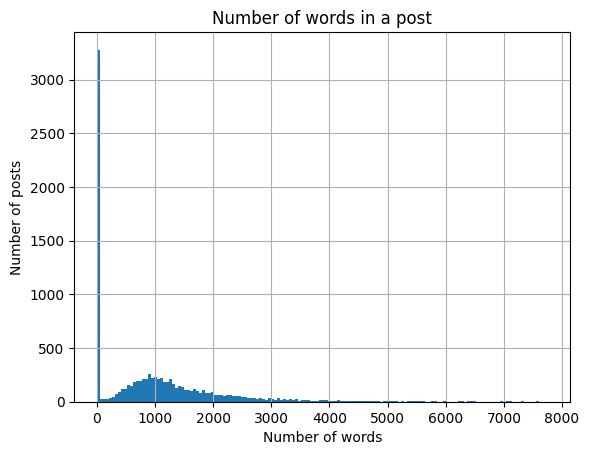

In [22]:
import matplotlib.pyplot as plt

ax = df.content.apply(lambda x: len(x.split(' '))).hist(bins=150)

# Adding titles and labels
ax.set_title('Number of words in a post')
ax.set_xlabel('Number of words')
ax.set_ylabel('Number of posts')

plt.show()


In [23]:
df1 = dataset.to_pandas()

In [26]:
df1.columns

Index(['date_utc', 'title', 'score', 'flair', 'content', 'poster', 'permalink',
       'id'],
      dtype='object')

In [25]:
ds1 = Dataset.from_pandas(df1)
ds1

Dataset({
    features: ['date_utc', 'title', 'score', 'flair', 'content', 'poster', 'permalink', 'id'],
    num_rows: 9840
})